# Example: Mixed-Element Mesh for Delineated Watershed

This workflow provides a part of worlflow to develop an streamaligned mixed-element mesh for Taylorupstream watershed. Long quad elements with pentagons at junctions are placed along NHDPlus flowlines to represent rivers/streams. Rest of the domain is meshed with standard TIN. This example has internal huc boundaries that are modified to accomodate river corridor. This workflow only shows steps to get a terrain following 2D surface mesh. Rest of the steps are same as other examples

It uses the following datasets:

* `NHD Plus` for the watershed boundary and hydrography.
* `NED` for elevation

In [1]:
## Importing all the package needed to run teh watershed workflow
# conda package imports
import os,sys
import numpy as np
import pandas
from matplotlib import pyplot as plt
import logging
import pandas as pd
import seaborn as sns
import copy
import scipy
import shapely

import watershed_workflow 
import watershed_workflow.source_list
import watershed_workflow.ui
import watershed_workflow.utils
import watershed_workflow.plot
import watershed_workflow.mesh
import watershed_workflow.densification
import watershed_workflow.condition
watershed_workflow.ui.setup_logging(1,None)

In [2]:
# Parameters cell -- this provides all parameters that can be changed via pipelining to generate a new watershed.
name = 'Taylor_Upstream' # name the domain, used in filenames, etc
hucs = ['140200010101','140200010102','140200010103'] # a list of HUCs to run
huc_level = 12 # if provided, an int setting the level at which to include HUC boundaries
modis_name = None

# geometric parameters
simplify = 100 # length scale to target average edge
simplify_rivers = 100
stream_outlet_width = 500 # half-width to track a labeled set on which to get discharge
ignore_small_rivers = 2 # ignore rivers which have this or fewer reaches.  likely they are irrigation ditches
                        # or other small features which make things complicated but likely don't add much value
prune_by_area_fraction = 0.02 # ignore reaches whose accumulated catchment area is less than this fraction of the
                              # full domain's area
prune_by_area_fraction_waterbodies = None
num_smoothing_sweeps = 5 # number of times to smooth the DEM prior to elevating

# simulation control
start_year = 1980  # year to start and end simulation simulation -- note these start and end Oct 1 of the year
end_year = 2020
min_porosity = 0.05 # minimum porosity considered too small
max_permeability = 1.e-10 # max value allowed for permeability
max_vg_alpha = 1.e-3 # max value of van Genuchten's alpha -- our correlation is not valid for some soils

# triangle refinement control
include_rivers = True
refine_d0 = 100
refine_d1 = 500
refine_A0 = 8000
refine_A1 = 50000

# soil structure
use_geologic_layer = True

# logistics
generate_plots = True # plots take time to make and aren't always needed
generate_daymet = True # potentially don't do Met data forcing
generate_modis = True

include_heterogeneous = True
include_homogeneous = False # if true, also write files for homogeneous runs
include_homogeneous_wrm = False # if true, also write files for homogeneous WRMs
include_homogeneous_wrm_porosity = False # if true, also write files for homogeneous porosity and WRMs
include_homogeneous_wrm_permeability = False # if true, also write files for homogeneous perm and WRMs

log_to_file = False  # if true, write to file instead of in the notebook output
figsize = (6,6)
figsize_3d = (8,6)

In [3]:
# parameter checking
assert(simplify > 0 and simplify < 300)
assert(ignore_small_rivers == None or (ignore_small_rivers >= 0 and ignore_small_rivers <= 100))
assert(prune_by_area_fraction == None or (prune_by_area_fraction >= 0 and prune_by_area_fraction < 1))
assert(start_year >= 1980 and start_year < 2020)

if type(hucs) is str:
    assert(hucs[0] == '[')
    assert(hucs[-1] == ']')
    hucs = hucs[1:-1]
    hucs = hucs.split(',')
    hucs = [h.strip() for h in hucs]
    if hucs[-1] == '':
        hucs = hucs[:-1]

if huc_level is None:
    huc_level = len(hucs[0])
else:
    assert(huc_level >= len(hucs[0]))
huc_key = f'HUC{huc_level}'

if prune_by_area_fraction_waterbodies is None:
    prune_by_area_fraction_waterbodies = prune_by_area_fraction * 0.1


In [4]:
# a dictionary of outputs -- will include all filenames generated
outputs = {}

In [5]:
# Note that, by default, we tend to work in the DayMet CRS because this allows us to avoid
# reprojecting meteorological forcing datasets.
crs = watershed_workflow.crs.daymet_crs()

## Sources and setup

Next we set up the source watershed and coordinate system and all data sources for our mesh.  We will use the CRS that is included in the shapefile.

In [6]:
logging.info("")
logging.info(f"Meshing shape: {hucs}")
logging.info("="*30)


2023-02-22 20:44:00,877 - root - INFO: 
2023-02-22 20:44:00,878 - root - INFO: Meshing shape: ['140200010101', '140200010102', '140200010103']
2023-02-22 20:44:00,878 - root - INFO: ==============================


A wide range of data sources are available; here we use the defaults except for using NHD Plus for watershed boundaries and hydrography (the default is NHD, which is lower resolution and therefore smaller download sizes).

In [7]:
# set up a dictionary of source objects
sources = watershed_workflow.source_list.get_default_sources()
sources['hydrography'] = watershed_workflow.source_list.hydrography_sources['NHD Plus']
sources['HUC'] = watershed_workflow.source_list.huc_sources['NHD Plus']
sources['DEM'] = watershed_workflow.source_list.dem_sources['NED 1/3 arc-second']
watershed_workflow.source_list.log_sources(sources)

2023-02-22 20:44:00,922 - root - INFO: Using sources:
2023-02-22 20:44:00,922 - root - INFO: --------------
2023-02-22 20:44:00,922 - root - INFO: HUC: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-02-22 20:44:00,923 - root - INFO: hydrography: National Hydrography Dataset Plus High Resolution (NHDPlus HR)
2023-02-22 20:44:00,923 - root - INFO: DEM: National Elevation Dataset (NED)
2023-02-22 20:44:00,924 - root - INFO: soil structure: National Resources Conservation Service Soil Survey (NRCS Soils)
2023-02-22 20:44:00,924 - root - INFO: geologic structure: GLHYMPS version 2.0
2023-02-22 20:44:00,924 - root - INFO: land cover: National Land Cover Database (NLCD) Layer: NLCD_2016_Land_Cover_L48
2023-02-22 20:44:00,924 - root - INFO: lai: MODIS
2023-02-22 20:44:00,925 - root - INFO: soil thickness: None
2023-02-22 20:44:00,925 - root - INFO: meteorology: DayMet 1km


In [8]:
# load the huc
my_hucs = []
for huc in hucs:
    _, ws = watershed_workflow.get_hucs(sources['HUC'], huc, huc_level, crs)
    my_hucs.extend(ws)

watershed = watershed_workflow.split_hucs.SplitHUCs(my_hucs)

2023-02-22 20:44:00,987 - root - INFO: 
2023-02-22 20:44:00,988 - root - INFO: Loading level 12 HUCs in 140200010101
2023-02-22 20:44:00,988 - root - INFO: ------------------------------
2023-02-22 20:44:00,989 - root - INFO: Using HUC file "/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2023-02-22 20:44:01,030 - root - INFO: ... found 1 HUCs
2023-02-22 20:44:01,031 - root - INFO:   -- 140200010101
2023-02-22 20:44:01,031 - root - INFO: Converting to out_crs
2023-02-22 20:44:01,037 - root - INFO: Converting to shapely
2023-02-22 20:44:01,038 - root - INFO: 
2023-02-22 20:44:01,038 - root - INFO: Loading level 12 HUCs in 140200010102
2023-02-22 20:44:01,039 - root - INFO: ------------------------------
2023-02-22 20:44:01,039 - root - INFO: Using HUC file "/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2023-02-22 20:44:01,070 - root - INFO: ... found 1 HUCs
2023-02-22 20:44:01,070 - root - IN

## Generate the surface mesh

First we'll generate the flattened, 2D triangulation, which builds on hydrography data.  Then we download a digital elevation map from the National Elevation Dataset, and extrude that 2D triangulation to a 3D surface mesh based on interpolation between pixels of the DEM.

### Get river network

This will download the river network from the NHD Plus database, and simplify the network, constructing a tree-like data structure.

In [9]:
# what about the reservoir!
_, waterbodies = watershed_workflow.get_waterbodies(sources['hydrography'], huc, my_hucs[0], crs, crs, 
                                                    prune_by_area=prune_by_area_fraction_waterbodies*my_hucs[0].area)

2023-02-22 20:44:01,161 - root - INFO: 
2023-02-22 20:44:01,161 - root - INFO: Loading Water Bodies
2023-02-22 20:44:01,161 - root - INFO: ------------------------------
2023-02-22 20:44:01,162 - root - INFO: Loading waterbodies in HUC 140200010103
2023-02-22 20:44:01,162 - root - INFO:          and/or bounds (-562803.8965103577, -359871.01201552415, -545801.220296083, -342804.74996838445)
2023-02-22 20:44:01,163 - root - INFO:   Using Hydrography file "/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2023-02-22 20:44:01,163 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb' layer 'NHDWaterbody' for streams in '(-562803.8965103577, -359871.01201552415, -545801.220296083, -342804.74996838445)'
2023-02-22 20:44:01,196 - root - INFO:   Found total of 368 in bounds.
2023-02-22 20:44:01,196 - root - INFO: ... foun

In [10]:
include_rivers=True

if include_rivers:  
    # download/collect the river network within that shape's bounds
    _, reaches = watershed_workflow.get_reaches(sources['hydrography'], "1402", 
                                                watershed.exterior(), crs, crs,
                                                in_network=True, properties=True)
    
    rivers = watershed_workflow.construct_rivers(watershed, reaches, method='hydroseq',
                                                 ignore_small_rivers=ignore_small_rivers,
                                                 prune_by_area_fraction=prune_by_area_fraction,
                                                 remove_diversions=True,
                                                 remove_braided_divergences=True)

2023-02-22 20:44:01,347 - root - INFO: 
2023-02-22 20:44:01,347 - root - INFO: Loading Hydrography
2023-02-22 20:44:01,348 - root - INFO: ------------------------------
2023-02-22 20:44:01,348 - root - INFO: Loading streams in HUC 1402
2023-02-22 20:44:01,349 - root - INFO:          and/or bounds (-562803.8965103577, -365142.00558721035, -534357.7588395509, -342804.74996838445)
2023-02-22 20:44:01,349 - root - INFO:   Using Hydrography file "/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb"
2023-02-22 20:44:01,350 - root - INFO:   National Hydrography Dataset Plus High Resolution (NHDPlus HR): opening '/Users/7s2/Research/watershed_workflow_data/hydrography/NHDPlus_H_1402_GDB/NHDPlus_H_1402.gdb' layer 'NHDFlowline' for streams in '(-562803.8965103577, -365142.00558721035, -534357.7588395509, -342804.74996838445)'
2023-02-22 20:44:01,566 - root - INFO:   Found total of 2479 in bounds.
2023-02-22 20:44:01,566 - root - INFO:   Filtering reaches

/Users/7s2/opt/anaconda3/envs/watershed_workflow-2022-08-29/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


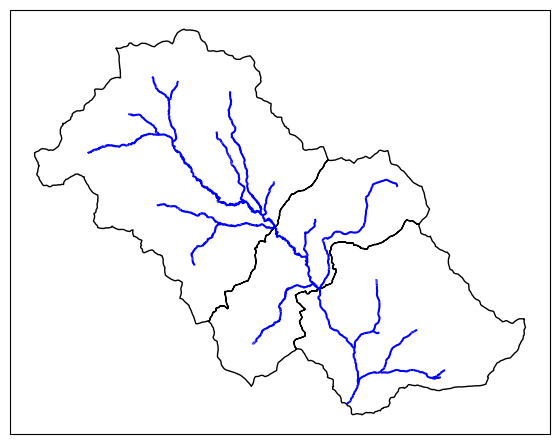

In [11]:
if generate_plots:
    fig = plt.figure(figsize=figsize)
    ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])    
    
    watershed_workflow.plot.hucs(watershed, crs, 'k', ax)
    watershed_workflow.plot.rivers(rivers, crs, 'b', ax)
    watershed_workflow.plot.shplys(waterbodies, crs, 'g', ax, facecolor='c')
    plt.show()

In [12]:
# keeping the originals
rivers_orig=[river.deep_copy() for river in rivers]
watershed_orig=copy.deepcopy(watershed) 

# simplifying 
rivers = watershed_workflow.simplify(watershed, rivers, simplify_hucs=150, simplify_rivers=80, merge_tol=50,
                           snap_rivers=True, cut_intersections=True)

# for plotting purpose only
rivers_simplified=[river.deep_copy() for river in rivers] 
watershed_simplified=copy.deepcopy(watershed) 

print('number of reaches in original', len(rivers_orig[0]), 'number of reaches in simplified', len(rivers[0]))

2023-02-22 20:44:03,824 - root - INFO: 
2023-02-22 20:44:03,825 - root - INFO: Simplifying
2023-02-22 20:44:03,825 - root - INFO: ------------------------------
2023-02-22 20:44:03,825 - root - INFO: Simplifying rivers
2023-02-22 20:44:03,843 - root - INFO:   ...cleaned inner segment of length 9.29357 at centroid (-544055.1068340249, -363377.48627413163)
2023-02-22 20:44:03,844 - root - INFO:   ...cleaned inner segment of length 20.5515 at centroid (-542663.4698560818, -362723.0546266398)
2023-02-22 20:44:03,845 - root - INFO:   ...cleaned inner segment of length 11.6351 at centroid (-542429.5430728602, -362698.18188702635)
2023-02-22 20:44:03,845 - root - INFO:   ...cleaned inner segment of length 10.4796 at centroid (-540965.1406121335, -360414.0907295551)
2023-02-22 20:44:03,846 - root - INFO:   ...cleaned inner segment of length 15.3334 at centroid (-540960.9389859297, -360408.11970226484)
2023-02-22 20:44:03,847 - root - INFO:   ...cleaned inner segment of length 28.6872 at centro

number of reaches in original 274 number of reaches in simplified 167


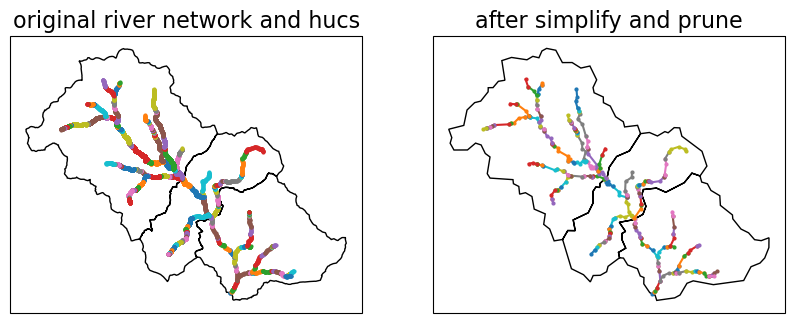

In [13]:
plt.rcParams['figure.figsize'] = [10, 10]
watershed_workflow.ui.setup_logging(1,None)

fig, axs = plt.subplots(1,2,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)})
watershed_workflow.plot.hucs(watershed_orig, crs, 'k', axs[0])
axs[0].set_title('original river network and hucs',fontsize=16)
watershed_workflow.plot.hucs(watershed, crs, 'k', axs[1])
axs[1].set_title('after simplify and prune',fontsize=16)

for river in rivers_orig:

    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=2)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=2)
plt.show()

In [14]:
d0 = 20; d1 = 100
L0 = 100; L1 = 250

# densify_watershed
watershed_workflow.densification.densify_hucs(watershed, watershed_orig, rivers, limit_scales=[d0,L0,d1,L1]) 

#densify_river
watershed_workflow.densification.densify_rivers(rivers, rivers_orig, limit=120)

2023-02-22 20:44:04,602 - root - INFO: trying to refine huc segment: 0
2023-02-22 20:44:04,606 - root - INFO: original huc segment 0 intersect huc segment 0 as <class 'shapely.geometry.multipoint.MultiPoint'>
2023-02-22 20:44:04,608 - root - INFO: original huc segment 1 intersect huc segment 0 as <class 'shapely.geometry.point.Point'>
2023-02-22 20:44:04,609 - root - INFO: original huc segment 2 intersect huc segment 0 as <class 'shapely.geometry.point.Point'>
2023-02-22 20:44:04,610 - root - INFO: original huc segment 3 do not intersect huc segment 0
2023-02-22 20:44:04,611 - root - INFO: original huc segment 4 intersect huc segment 0 as <class 'shapely.geometry.multipoint.MultiPoint'>
2023-02-22 20:44:04,612 - root - INFO: original huc segment 5 do not intersect huc segment 0
2023-02-22 20:44:04,613 - root - INFO: did not find corresponding huc.segment in original, doing simple interpolation
2023-02-22 20:44:04,655 - root - INFO: trying to refine huc segment: 1
2023-02-22 20:44:04,65

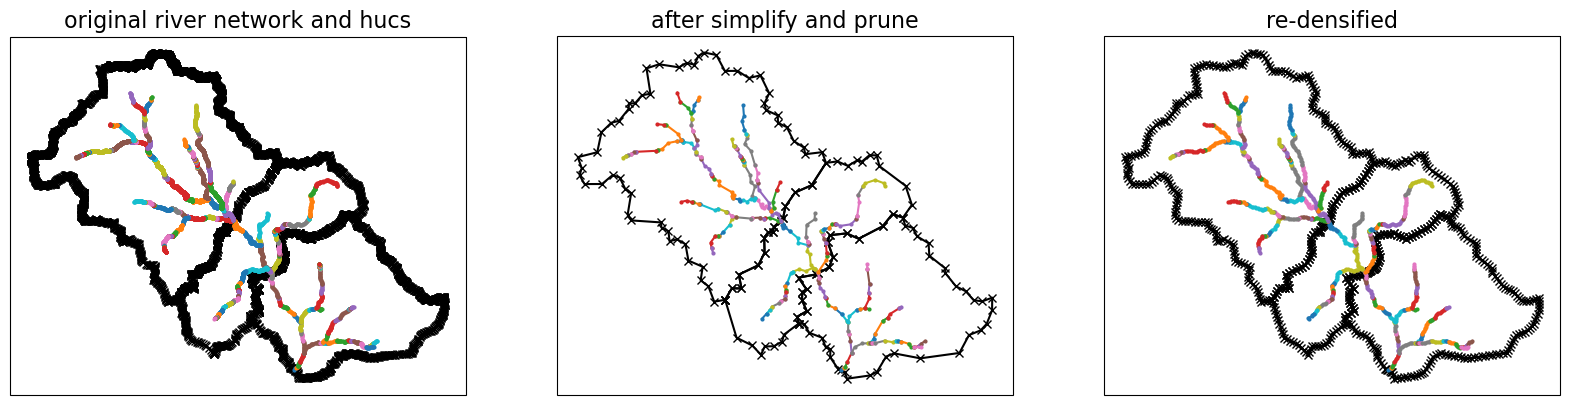

In [15]:
# plotting results
plt.rcParams['figure.figsize'] = [20, 12]

fig, axs = plt.subplots(1,3,subplot_kw={'projection':watershed_workflow.crs.to_cartopy(crs)})

for huc in list(watershed_orig.polygons()):
    axs[0].plot(huc.exterior.xy[0], huc.exterior.xy[1], 'k-x')
axs[0].set_title('original river network and hucs',fontsize=16)
for huc in list(watershed_simplified.polygons()):
    axs[1].plot(huc.exterior.xy[0], huc.exterior.xy[1], 'k-x')
axs[1].set_title('after simplify and prune',fontsize=16)
for huc in list(watershed.polygons()):
    axs[2].plot(huc.exterior.xy[0], huc.exterior.xy[1], 'k-x')
axs[2].set_title('re-densified',fontsize=16)
axs[2].plot()

for river in rivers_orig:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[0].plot(x,y,'-o',markersize=2)

for river in rivers_simplified:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[1].plot(x,y,'-o',markersize=2)

for river in rivers:
    for node in river.preOrder():
        x,y=node.segment.xy 
        axs[2].plot(x,y,'-o',markersize=2)
plt.show()

In [16]:
# how many types of Stream Orders are there
set([r.properties["StreamOrder"] for r in rivers[0].preOrder()])

{2, 3, 4, 5}

2023-02-22 20:44:05,339 - root - INFO: creating river corridor polygon
2023-02-22 20:44:05,339 - root - INFO: river min seg length: 51.644597373587295
2023-02-22 20:44:05,340 - root - INFO: merging points closer than this distance along the river corridor: 43.644597373587295
2023-02-22 20:44:05,352 - root - INFO: defining river-mesh topology (quad elements)
2023-02-22 20:44:05,421 - root - INFO: setting width of quad elements based on StreamOrder
2023-02-22 20:44:05,436 - root - INFO:   adjusting HUC boundary to include the river outlet segments
2023-02-22 20:44:05,440 - root - INFO:   ... found an intersection of river and huc seg
2023-02-22 20:44:05,441 - root - INFO:   ... it is an unadjusted outlet!
2023-02-22 20:44:05,442 - root - INFO:   ... is there a parent to this? None
2023-02-22 20:44:05,443 - root - INFO: found outlet junction
2023-02-22 20:44:05,444 - root - INFO: Modifying HUC Segment 6
2023-02-22 20:44:05,445 - root - INFO: Modifying HUC Segment 3
2023-02-22 20:44:05,446

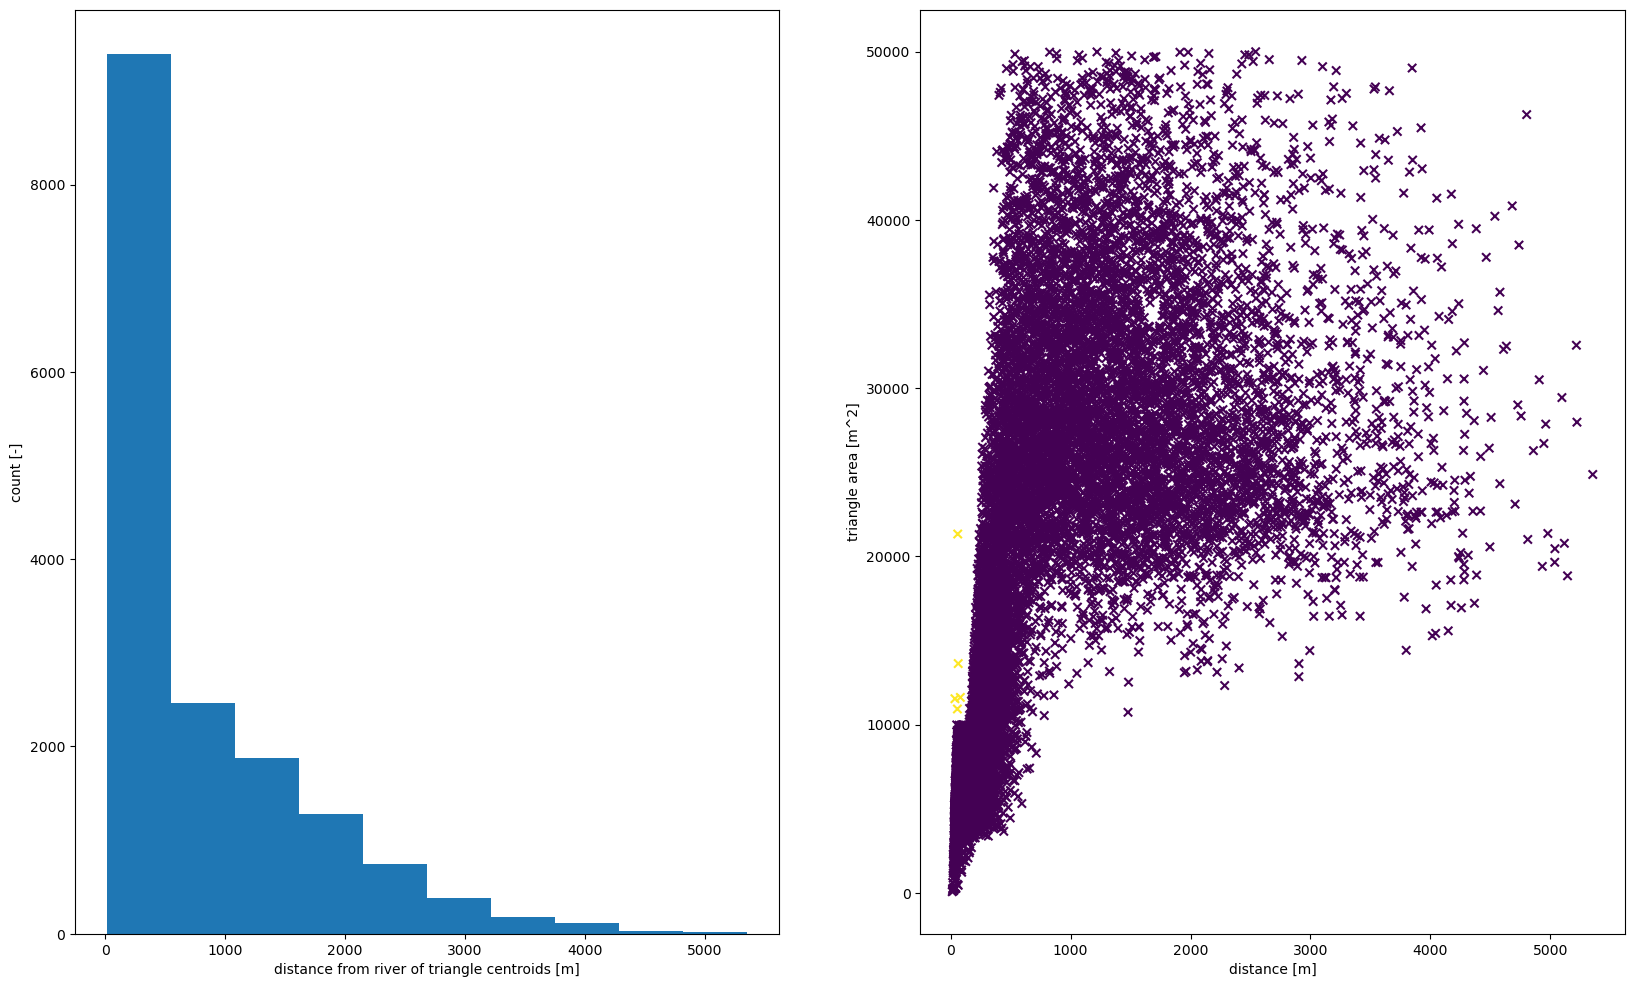

In [17]:
## Triangulation

refine_d0 = 150 
refine_d1 = 400
refine_A0 = 10000
refine_A1 = 50000

d0 = refine_d0; d1 = refine_d1
A0 = refine_A0; A1 = refine_A1 

# Refine triangles if they get too acute
min_angle = 32 # degrees

# width of reach by stream order (order:width)
widths = dict({2:10,3:20,4:30,5:30}) 

mesh_points2, conn_list, areas, dists = watershed_workflow.tessalate_river_aligned(watershed,rivers, river_width=widths,
                                              refine_min_angle=min_angle,refine_distance=[d0,A0,d1,A1],
                                              diagnostics=True)

In [18]:
# get a raster for the elevation map, based on NED
dem_profile, dem = watershed_workflow.get_raster_on_shape(sources['DEM'], watershed.exterior(), crs)

# elevate the triangle nodes to the dem
mesh_points3 = watershed_workflow.elevate(mesh_points2, crs, dem, dem_profile)

2023-02-22 20:44:39,561 - root - INFO: 
2023-02-22 20:44:39,562 - root - INFO: Loading Raster
2023-02-22 20:44:39,563 - root - INFO: ------------------------------
2023-02-22 20:44:39,565 - root - INFO: Collecting raster
2023-02-22 20:44:39,572 - root - INFO: Collecting DEMs to tile bounds: [-106.81032954674818, 38.84352861677489, -106.43913707958494, 39.06593763312742]
2023-02-22 20:44:39,572 - root - INFO:   Need:
2023-02-22 20:44:39,572 - root - INFO:     /Users/7s2/Research/watershed_workflow_data/dem/USGS_NED_13as_n39_w107.tif
2023-02-22 20:44:39,573 - root - INFO:     /Users/7s2/Research/watershed_workflow_data/dem/USGS_NED_13as_n40_w107.tif
2023-02-22 20:44:39,573 - root - INFO: source files already exist!
2023-02-22 20:44:39,936 - root - INFO: ... got raster of shape: (2402, 4009)
2023-02-22 20:44:39,937 - root - INFO: ... got raster bounds: (-106.81032954674818, 39.06593763312742, -106.43912584264514, 38.84353022528096)


In [19]:
# construct the 2D mesh
m2 = watershed_workflow.mesh.Mesh2D(mesh_points3.copy(), conn_list)

In [20]:
# hydrologically condition the mesh, removing pits
river_mask=np.zeros((len(m2.conn)))
for i, elem in enumerate(m2.conn):
    if not len(elem)==3:
        river_mask[i]=1     
watershed_workflow.condition.fill_pits_dual(m2, is_waterbody=river_mask)

In [21]:
# conditioning river mesh
#
# adding elevations to the river tree for stream bed conditioning
watershed_workflow.condition.elevate_rivers(rivers, crs, dem, dem_profile)

# conditioning the river mesh using NHD elevations
watershed_workflow.condition.condition_river_mesh(m2, river)

kwargs =  {'linewidth': 0.1, 'cmap': <matplotlib.colors.ListedColormap object at 0x16e351c90>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x16e3532b0>, 'edgecolor': 'w'}
setting face color =  [2961.44476666 3615.68808215 3293.70655708 ... 2977.29552727 2980.86625463
 2984.04363978]
kwargs =  {'linewidth': 0.25, 'cmap': <matplotlib.colors.ListedColormap object at 0x16e351c90>, 'norm': <matplotlib.colors.BoundaryNorm object at 0x16e3532b0>, 'edgecolor': 'w'}
setting face color =  [2961.44476666 3615.68808215 3293.70655708 ... 2977.29552727 2980.86625463
 2984.04363978]


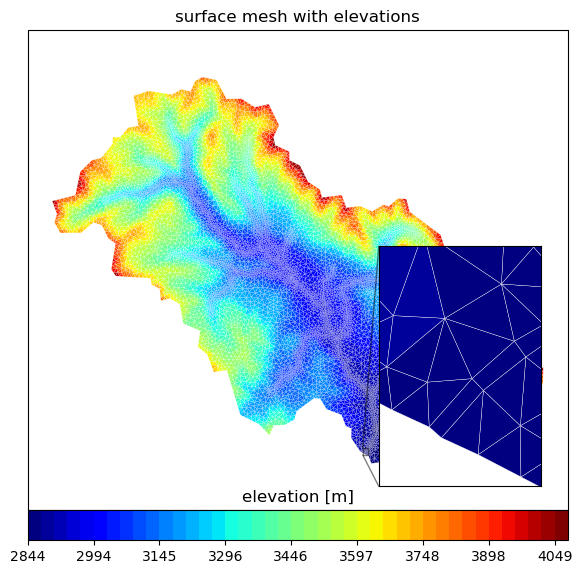

In [22]:
# plotting surface mesh with elevations
start=min(m2.centroids[:,2])
step=(max(m2.centroids[:,2])-(min(m2.centroids[:,2])))/40
stop=max(m2.centroids[:,2])+step
legend_values=np.arange(start,stop,step)
indices, cmap, norm, ticks, labels = watershed_workflow.colors.generate_indexed_colormap(legend_values, cmap='jet')


fig = plt.figure(figsize=figsize)
ax = watershed_workflow.plot.get_ax(crs, fig, window=[0.05,0.1,0.9,0.8])
ax2 = ax.inset_axes([0.65,0.05,0.3,0.5])
cbax = fig.add_axes([0.05,0.05,0.9,0.05])

mp = watershed_workflow.plot.mesh(m2, crs, ax=ax, 
                        linewidth=0.1 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='w', facecolor='color')
cbar = fig.colorbar(mp, orientation="horizontal", cax=cbax)
ax.set_title('surface mesh with elevations')
ax.set_aspect('equal', 'datalim')

mp2 = watershed_workflow.plot.mesh(m2, crs, ax=ax2, 
                        linewidth=0.25 ,color=m2.centroids[:,2], 
                        cmap=cmap, norm = norm, edgecolor='w', facecolor='color')
ax2.set_aspect('equal', 'datalim')

xlim =(-544850, -544550)
ylim = (-364650, -364250)

ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xticks([])
ax2.set_yticks([])

ax.indicate_inset_zoom(ax2, edgecolor='k')

cbar.ax.set_title('elevation [m]')

plt.show()


In [23]:
# find outlet
watershed_workflow.split_hucs.find_outlets_by_hydroseq(watershed, rivers[0])

In [24]:
# add labeled sets for subcatchments and outlets
watershed_workflow.mesh.add_watershed_regions_and_outlets(m2, watershed, outlet_width=stream_outlet_width, 
                                                          labels=[p.properties[huc_key] for p in watershed.polygons()])

# add river corridor as region (this requires creating river corridor again); is there a better way?
corrs = watershed_workflow.river_mesh.create_rivers_meshes(rivers, widths=widths, enforce_convexity=True, ax=None)[1]
watershed_workflow.mesh.add_river_corridor_regions(m2, corrs)

2023-02-22 20:44:45,452 - root - INFO: creating river corridor polygon
2023-02-22 20:44:45,453 - root - INFO: river min seg length: 51.644597373587295
2023-02-22 20:44:45,453 - root - INFO: merging points closer than this distance along the river corridor: 43.644597373587295
2023-02-22 20:44:45,465 - root - INFO: defining river-mesh topology (quad elements)
2023-02-22 20:44:45,525 - root - INFO: setting width of quad elements based on StreamOrder


In [25]:
for ls in m2.labeled_sets:
    print(f'{ls.setid} : {ls.entity} : "{ls.name}"')

10000 : CELL : "140200010101"
10001 : CELL : "140200010101 surface"
10002 : CELL : "140200010102"
10003 : CELL : "140200010102 surface"
10004 : CELL : "140200010103"
10005 : CELL : "140200010103 surface"
10006 : FACE : "140200010101 boundary"
10007 : FACE : "140200010101 outlet"
10008 : FACE : "140200010102 boundary"
10009 : FACE : "140200010102 outlet"
10010 : FACE : "140200010103 boundary"
10011 : FACE : "140200010103 outlet"
10012 : FACE : "surface domain outlet"
10013 : CELL : "river_corridor 0 surface"
